<a href="https://colab.research.google.com/github/ardilalukita14/Magang-Kominfo/blob/main/Mining_Merge_Keyword.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Install Library yang Dibutuhkan**

In [1]:
!pip install GoogleNews

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 288 kB 7.9 MB/s 
     |████████████████████████████████| 749 kB 44.4 MB/s 
  Attempting uninstall: regex
    Found existing installation: regex 2022.6.2
    Uninstalling regex-2022.6.2:
      Successfully uninstalled regex-2022.6.2


In [4]:
!pip install pygooglenews

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
!pip install Sastrawi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 209 kB 6.8 MB/s 


In [6]:
!pip install newspaper3k

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 211 kB 7.6 MB/s 
     |████████████████████████████████| 93 kB 1.9 MB/s 
     |████████████████████████████████| 7.4 MB 44.7 MB/s 
  Created wheel for tinysegmenter: filename=tinysegmenter-0.3-py3-none-any.whl size=13553 sha256=188dc82c3fd0f0a7cc9e17e1cf61d8c84046bbf98ff4271a0d98c5f2c45ea966
  Stored in directory: /root/.cache/pip/wheels/df/67/41/faca10fa501ca010be41b49d40360c2959e1c4f09bcbfa37fa
  Created wheel for feedfinder2: filename=feedfinder2-0.0.4-py3-none-any.whl size=3357 sha256=dca5ad0f2c9d521600da17fa2709a3220668195b450b94950538b7a7e0aeab0e
  Stored in directory: /root/.cache/pip/wheels/7f/d4/8f/6e2ca54744c9d7292d88ddb8d42876bcdab5e6d84a21c10346
  Created wheel for jieba3k: filename=jieba3k-0.35.1-py3-none-any.whl size=7398404 sha256=f24e9ed27c200096bae4ce1e64bbedb0446882e598af6c19bd370e197a41cdd5
  Stored in directory: /root/.cache/pip/

In [8]:
!pip install wordcloud

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## **Proses Scraping, Stemming, Stop Words Google News**

In [9]:
# import library 
from pygooglenews import GoogleNews
import csv
from newspaper import Article
import nltk
import ssl
try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context
nltk.download('punkt')
from pprint import pprint
from textblob import TextBlob
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import datetime
import pandas as pd
from time import sleep
#from google.colab import files


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [11]:
f = open("stop words.txt", "r")
stopword_list = []
for line in f:
    stripped_line = line.strip()
    line_list = stripped_line.split()
    stopword_list.append(line_list[0])
f.close()

len(stopword_list)

758

In [12]:

# Scrapping Function to get google news (title, link)
gn = GoogleNews(lang = 'id',country = 'ID') 
def get_titles(search):
    stories = []

    # setting tanggal
    start_date = datetime.date(2022,7,1)
    end_date = datetime.date(2022,7,16)
    delta = datetime.timedelta(days=1)
    date_list = pd.date_range(start_date, end_date).tolist()
    
    for date in date_list[:-1]:
        result = gn.search(search, from_=date.strftime('%Y-%m-%d'), to_=(date+delta).strftime('%Y-%m-%d'), when = '1d')
        newsitem = result['entries']
   # stemmer
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()

    for item in newsitem:
        url=item.link
        try:
            article = Article(url)
            article.download()
            article.parse()
            story = {
                'Title' : item.title,
                'Read more' : item.link,
                'Time' : item.published,
                'Article' : article.title,
                'Stemming' : stemmer.stem(article.title),
                'WordTokens' :(word_tokenize(stemmer.stem(article.title))),
                'WordsStop' : [w for w in (word_tokenize(stemmer.stem(article.title))) if not w in stopword_list ],
                'TotalKata' : len([w for w in (word_tokenize(stemmer.stem(article.title))) if not w in stopword_list ])
                }
            if article.title=="Are you a robot?" or article.title=="Subscribe to read" :
                continue
            else:
                stories.append(story)
                i=i+1
                print(i,'',article.title)
                sleep(1)
        except:
              pass
        stories.append(story)
        sleep(0)
    return stories


In [13]:
# Process Summarize Goolge News Article + Sentiment Analysis of Google News
def summarize_artcle(url):
    article = Article(url)
    # Set up 
    article.download()
    article.parse()
    # Download Punkt
    article.download('punkt')
    article.nlp()
    summary = article.summary

    analysis = TextBlob(article.text)
    sentiment_a =""
    if analysis.polarity > 0:
      sentiment_a="positif"
    elif analysis.polarity < 0:
      sentiment_a="negatif"
    else:
       sentiment_a="netral"

    return summary,sentiment_a

In [19]:
#Function to save a list
def save_dict(topic, number):
    try: 
      dcts = get_titles(topic)
      news_list = []
      for x in range(number):
        dctss = dcts[x]
        url = dctss['Read more']
        try:
          summary_analysis = list(summarize_artcle(url))
          dctss['Sentiment'] = summary_analysis[1]
          dctss['Summary'] = summary_analysis[0]
        except:
          dctss['Sentiment'] = 'error'
          dctss['Summary'] ='error'
        news_list.append(dctss)
        pprint(dctss)
      return news_list 
    except:
        print('Please input useable topics, thanks or check this -> https://github.com/kotartemiy/pygooglenews#installation')

In [45]:
#Function to Save a CSV file
def save_to_csv(news_list):
    labels = ['Time', 'Title', 'Read more','Sentiment','Summary', 'Article', 'Stemming', 'WordTokens', 'WordsStop', 'TotalKata']
    try:
        with open(file, 'w') as f:
            writer = csv.DictWriter(f, fieldnames=labels)
            writer.writeheader()
            for elem in news_list:
                writer.writerow(elem)
        print("Download csv Sucessfully")
    except IOError:
        print("I/O error")
file = input('Rename file: ')

Rename file: data2.csv


In [46]:
# Let's run this    
print("Hi, there!")
topic = input('Now Enter your topics to Search or Exit: ')
while topic != 'Exit':
  number = int(input('How many articles you want to search (up to 100)? '))
  news_data = save_dict(topic, number)
  try:
    save_to_csv(news_data)
    #save_to_csv2(news_data)
  except:
    print("Retry it again!")
  topic = input('Now Enter Your Topics to Search or Exit: ')
print('See you, hope you have a great day! ❤️')

Hi, there!
Now Enter your topics to Search or Exit: madiun
How many articles you want to search (up to 100)? 10
{'Article': 'Wali Kota Madiun Harap Okupansi Rumah Sakit Semakin Turun',
 'Read more': 'https://www.harianbhirawa.co.id/wali-kota-madiun-harap-okupansi-rumah-sakit-semakin-turun/',
 'Sentiment': 'netral',
 'Stemming': 'wali kota madiun harap okupansi rumah sakit makin turun',
 'Summary': '',
 'Time': 'Sun, 17 Jul 2022 14:12:09 GMT',
 'Title': 'Wali Kota Madiun Harap Okupansi Rumah Sakit Semakin Turun - Harian '
          'Bhirawa',
 'TotalKata': 8,
 'WordTokens': ['wali',
                'kota',
                'madiun',
                'harap',
                'okupansi',
                'rumah',
                'sakit',
                'makin',
                'turun'],
 'WordsStop': ['wali',
               'kota',
               'madiun',
               'harap',
               'okupansi',
               'rumah',
               'sakit',
               'turun']}
{'Article': 

## **Join Dataset**

In [47]:
d1 = pd.read_csv(input('masukkan nama file 1 : '))
d2 = pd.read_csv(input('masukkan nama file 2 : '))
frames = [d1, d2] 
result = pd.concat(frames).drop_duplicates().reset_index(drop=True)

masukkan nama file 1 : data.csv
masukkan nama file 2 : data2.csv


In [48]:
result.to_csv(r'join.csv', index=False)

In [49]:
df2 = input("Upload file CSV: ")
df3 = pd.read_csv(df2)
df3

Upload file CSV: join.csv


,Time,Title,Read more,Sentiment,Summary,Article,Stemming,WordTokens,WordsStop,TotalKata
0,"Sun, 17 Jul 2022 09:49:05 GMT","Apresiasi Liga Puter Jatim Putaran II, Wali Ko...",https://madiuntoday.id/2022/07/17/apresiasi-li...,netral,"Melihat antusiasme yang tinggi itu, Wali Kota ...","Apresiasi Liga Puter Jatim Putaran II, Wali Ko...",apresiasi liga puter jatim putar ii wali kota ...,"['apresiasi', 'liga', 'puter', 'jatim', 'putar...","['apresiasi', 'liga', 'puter', 'jatim', 'putar...",13
1,"Sun, 17 Jul 2022 16:50:59 GMT",Madiun Lawu Challenge (MLC) 2022 ajang promosi...,https://jatim.antaranews.com/berita/619989/mad...,positif,Para peserta ajang balap sepeda Madiun Lawu Ch...,Madiun Lawu Challenge (MLC) 2022 ajang promosi...,madiun lawu challenge mlc 2022 ajang promosi w...,"['madiun', 'lawu', 'challenge', 'mlc', '2022',...","['madiun', 'lawu', 'challenge', 'mlc', '2022',...",10
2,"Sun, 17 Jul 2022 13:20:24 GMT","Hadiri Kunjungan Menhub Budi di PT Inka, Wali ...",https://madiuntoday.id/2022/07/17/hadiri-kunju...,netral,MADIUN – Menteri Perhubungan Budi Karya Sumadi...,"Hadiri Kunjungan Menhub Budi di PT Inka, Wali ...",hadir kunjung menhub budi di pt inka wali kota...,"['hadir', 'kunjung', 'menhub', 'budi', 'di', '...","['hadir', 'kunjung', 'menhub', 'budi', 'pt', '...",11
3,"Sun, 17 Jul 2022 13:25:39 GMT","Saksikan Persik Kediri Vs Persis Solo, Wali Ko...",https://madiuntoday.id/2022/07/17/saksikan-per...,netral,"MADIUN – Wali Kota Madiun, Maidi kembali menya...","Saksikan Persik Kediri Vs Persis Solo, Wali Ko...",saksi persik diri vs persis solo wali kota apr...,"['saksi', 'persik', 'diri', 'vs', 'persis', 's...","['saksi', 'persik', 'vs', 'persis', 'solo', 'w...",10
4,"Mon, 18 Jul 2022 07:00:18 GMT","Buka MPLS 2022, Wali Kota Dorong Optimalisasi ...",https://madiuntoday.id/2022/07/18/buka-mpls-20...,netral,MADIUN – Masa Pengenalan Lingkungan Sekolah (M...,"Buka MPLS 2022, Wali Kota Dorong Optimalisasi ...",buka mpls 2022 wali kota dorong optimalisasi t...,"['buka', 'mpls', '2022', 'wali', 'kota', 'doro...","['buka', 'mpls', '2022', 'wali', 'kota', 'doro...",10
5,"Sun, 17 Jul 2022 14:12:09 GMT",Wali Kota Madiun Harap Okupansi Rumah Sakit Se...,https://www.harianbhirawa.co.id/wali-kota-madi...,netral,NaN,Wali Kota Madiun Harap Okupansi Rumah Sakit Se...,wali kota madiun harap okupansi rumah sakit ma...,"['wali', 'kota', 'madiun', 'harap', 'okupansi'...","['wali', 'kota', 'madiun', 'harap', 'okupansi'...",8
6,"Mon, 18 Jul 2022 01:45:00 GMT",Twibbon Hari Jadi Kab Madiun ke 454 Tahun 2022...,https://mediajabodetabek.pikiran-rakyat.com/na...,netral,MEDIA JABODETABEK - Download twibbon Hari Jadi...,Twibbon Hari Jadi Kab Madiun ke 454 Tahun 2022...,twibbon hari jadi kab madiun ke 454 tahun 2022...,"['twibbon', 'hari', 'jadi', 'kab', 'madiun', '...","['twibbon', 'kab', 'madiun', '454', '2022', 'c...",10
7,"Sun, 17 Jul 2022 08:30:00 GMT","Viral, Video Bus Terobos Marka Jalan dan Serem...",https://www.kompas.com/tren/read/2022/07/17/15...,netral,NaN,"Viral, Video Bus Terobos Marka Jalan dan Serem...",viral video bus terobos marka jalan dan seremp...,"['viral', 'video', 'bus', 'terobos', 'marka', ...","['viral', 'video', 'bus', 'terobos', 'marka', ...",15


Masukkan file: join.csv


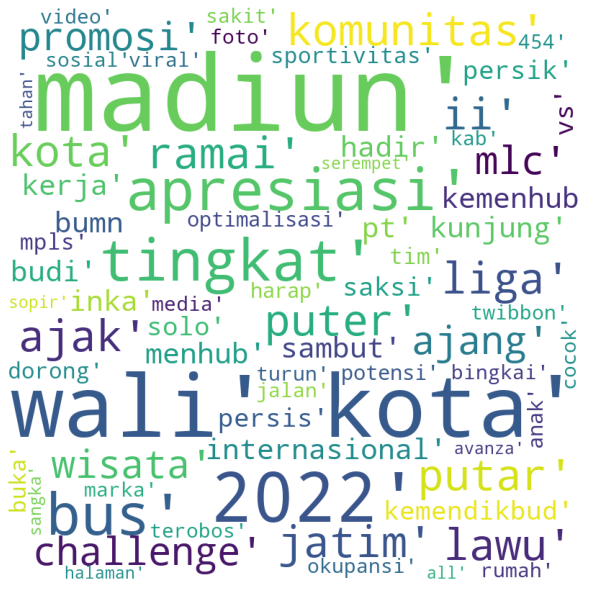

In [50]:
# Python program to generate WordCloud
 
# importing all necessary modules
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import pandas as pd
 
# Reads 'Youtube04-Eminem.csv' file
df = pd.read_csv((input('Masukkan file: ')), encoding ="latin-1")
 
comment_words = ''
stopwords = set(STOPWORDS)
 
# iterate through the csv file
for val in df.WordsStop:
     
    # typecaste each val to string
    val = str(val)
 
    # split the value
    tokens = val.split()
     
    # Converts each token into lowercase
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
     
    comment_words += " ".join(tokens)+" "
 
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(comment_words)
 
# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()